# Fine-tuning a masked language model

For many NLP applications involving Transformer models, you can simply take a pretrained model from the Hugging Face Hub and fine-tune it directly on your data for the task at hand. Provided that the corpus used for pretraining is not too different from the corpus used for fine-tuning, transfer learning will usually produce good results.



However, there are a few cases where you’ll want to first fine-tune the language models on your data, before training a task-specific head. For example, if your dataset contains legal contracts or scientific articles, a vanilla Transformer model like BERT will typically treat the domain-specific words in your corpus as rare tokens, and the resulting performance may be less than satisfactory. By fine-tuning the language model on in-domain data you can boost the performance of many downstream tasks, which means you usually only have to do this step once!



This process of fine-tuning a pretrained language model on in-domain data is usually called **domain adaptation**. It was popularized in 2018 by ULMFiT, which was one of the first neural architectures (based on LSTMs) to make transfer learning really work for NLP. An example of domain adaptation with ULMFiT is shown in the image below; in this section we’ll do something similar, but with a Transformer instead of an LSTM!



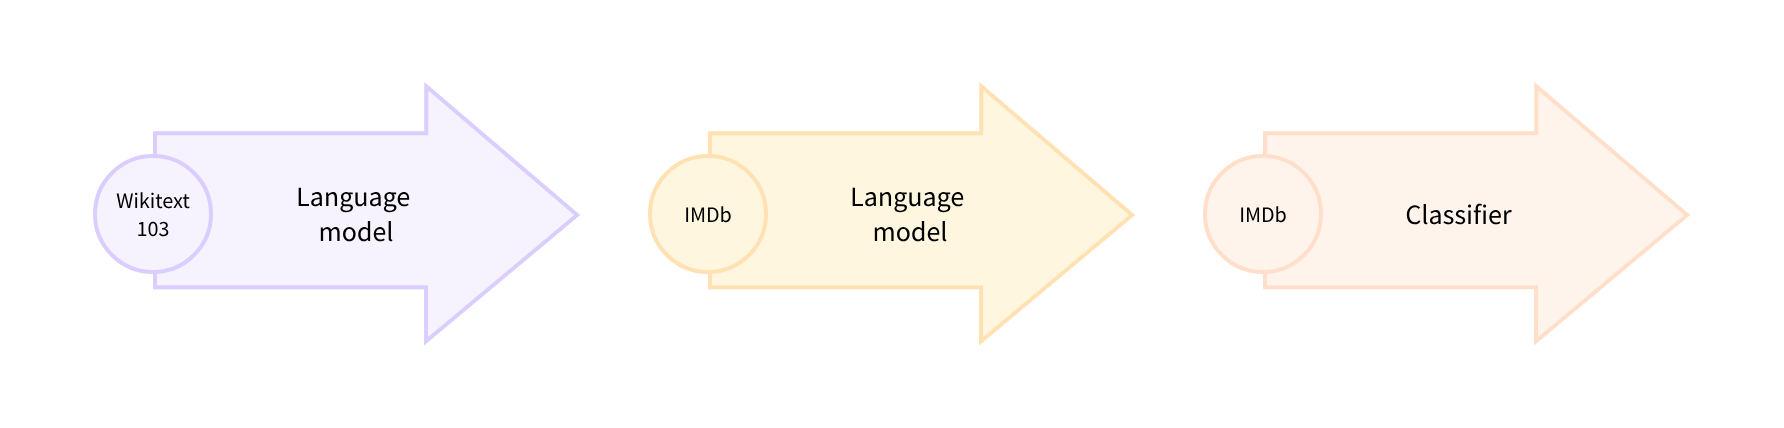

## 1. Picking a pretrained model for masked language modeling

Although the BERT and RoBERTa family of models are the most downloaded, we’ll use a model called DistilBERT that can be trained much faster with little to no loss in downstream performance. This model was trained using a special technique called knowledge distillation, where a large “teacher model” like BERT is used to guide the training of a “student model” that has far fewer parameters.

In [1]:
from transformers import AutoModelForMaskedLM

checkpoint = "distilbert-base-uncased"
model = AutoModelForMaskedLM.from_pretrained(checkpoint)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


Loading weights:   0%|          | 0/105 [00:00<?, ?it/s]

We can see how many parameters this model has by calling the `num_parameters()` method:



In [2]:
distilbert_num_params = model.num_parameters() / 1_000_000
print(f'{distilbert_num_params} million parameters')

66.98553 million parameters


With around 67 million parameters, DistilBERT is approximately two times smaller than the BERT base model, which roughly translates into a two-fold speedup in training — nice! Let’s now see what kinds of tokens this model predicts are the most likely completions of a small sample of text:

In [3]:
text = "This is a great [MASK]."

For pretrained models, the predictions depend on the corpus the model was trained on, since it learns to pick up the statistical patterns present in the data. Like BERT, DistilBERT was pretrained on the English Wikipedia and BookCorpus datasets, so we expect the predictions for `[MASK]` to reflect these domains. To predict the mask we need DistilBERT’s tokenizer to produce the inputs for the model, so let’s download that from the Hub as well:

In [36]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)

With a tokenizer and a model, we can now pass our text example to the model, extract the logits, and print out the top 5 candidates:



In [5]:
import torch

inputs = tokenizer(text, return_tensors='pt')
logits = model(**inputs).logits
print(logits.shape)
# Find the location of [MASK]
mask_token_idx = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
mask_token_logits = logits[0, mask_token_idx, :]
# topk function return values, indices -> shape of indices is (1, 5)
# 1 mask position, 5 highest probability logits
top5_tokens = torch.topk(mask_token_logits, 5, dim=-1).indices[0].tolist()

for token in top5_tokens:
    print(f"{text.replace(tokenizer.mask_token, tokenizer.decode([token]))}")

torch.Size([1, 8, 30522])
This is a great deal.
This is a great success.
This is a great adventure.
This is a great idea.
This is a great feat.


## 2. The dataset

To showcase domain adaptation, we’ll use the famous Large Movie Review Dataset (or IMDb for short), which is a corpus of movie reviews that is often used to benchmark sentiment analysis models. By fine-tuning DistilBERT on this corpus, we expect the language model will adapt its vocabulary from the factual data of Wikipedia that it was pretrained on to the more subjective elements of movie reviews. 

In [6]:
from datasets import load_dataset

imdb_dataset = load_dataset('imdb')
imdb_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

We can see that the `train` and `test` splits each consist of 25,000 reviews, while there is an unlabeled split called `unsupervised` that contains 50,000 reviews. Let’s take a look at a few samples to get an idea of what kind of text we’re dealing with. As we’ve done in previous chapters of the course, we’ll chain the `Dataset.shuffle()` and` Dataset.select()` functions to create a random sample:



In [7]:
sample = imdb_dataset["train"].shuffle(seed=42).select(range(5))

for row in sample:
    print(row["text"])
    print(row["label"])

There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier's plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it's the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...
1
This movie is a great. The plot is very true to the book which is a classic written by Mark Twain. The movie starts of with a scene where Hank sings a song with a bunch of kids called "when you stub your toe on the moon" It reminds me of S

Although we won’t need the labels for language modeling, we can already see that a 0 denotes a negative review, while a 1 corresponds to a positive one.

In [8]:
imdb_dataset["unsupervised"][:3]

{'text': ['This is just a precious little diamond. The play, the script are excellent. I cant compare this movie with anything else, maybe except the movie "Leon" wonderfully played by Jean Reno and Natalie Portman. But... What can I say about this one? This is the best movie Anne Parillaud has ever played in (See please "Frankie Starlight", she\'s speaking English there) to see what I mean. The story of young punk girl Nikita, taken into the depraved world of the secret government forces has been exceptionally over used by Americans. Never mind the "Point of no return" and especially the "La femme Nikita" TV series. They cannot compare the original believe me! Trash these videos. Buy this one, do not rent it, BUY it. BTW beware of the subtitles of the LA company which "translate" the US release. What a disgrace! If you cant understand French, get a dubbed version. But you\'ll regret later :)',
  'When I say this is my favourite film of all time, that comment is not to be taken lightly

## 3. Preprocessing the data

For both auto-regressive and masked language modeling, a common preprocessing step is to concatenate all the examples and then split the whole corpus into chunks of equal size. This is quite different from our usual approach, where we simply tokenize individual examples. Why concatenate everything together? The reason is that individual examples might get truncated if they’re too long, and that would result in losing information that might be useful for the language modeling task!



So to get started, we’ll first tokenize our corpus as usual, but without setting the `truncation=True` option in our tokenizer. We’ll also grab the word IDs, as we will need them later on to do whole word masking. We’ll wrap this in a simple function, and while we’re at it we’ll remove the text and label columns since we don’t need them any longer:

In [ ]:
def tokenize_func(example):
    # DataCollatorForWholeWordMask cần offset_mapping hợp lệ
    result = tokenizer(example["text"], return_offsets_mapping=True)
    result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result

In [38]:
tokenized_dataset = imdb_dataset.map(
    tokenize_func, 
    batched=True, 
    remove_columns=imdb_dataset["train"].column_names
)
tokenized_dataset

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (532 > 512). Running this sequence through the model will result in indexing errors


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'word_ids'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'word_ids'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'word_ids'],
        num_rows: 50000
    })
})

Since DistilBERT is a BERT-like model, we can see that the encoded texts consist of the `input_ids` and `attention_mask` that we’ve seen in other chapters, as well as the `word_ids` we added.



Now that we’ve tokenized our movie reviews, the next step is to group them all together and split the result into chunks. But how big should these chunks be? This will ultimately be determined by the amount of GPU memory that you have available, but a good starting point is to see what the model’s maximum context size is. This can be inferred by inspecting the `model_max_length` attribute of the tokenizer:



In [11]:
tokenizer.model_max_length

512

This value is derived from the `tokenizer_config.json` file associated with a checkpoint; in this case we can see that the context size is 512 tokens, just like with BERT.



So, in order to run our experiments on GPUs like those found on Google Colab, we’ll pick something a bit smaller that can fit in memory:



In [12]:
chunk_size = 256

Note that using a small chunk size can be detrimental in real-world scenarios, so you should use a size that corresponds to the use case you will apply your model to.



Now comes the fun part. To show how the concatenation works, let’s take a few reviews from our tokenized training set and print out the number of tokens per review:



In [13]:
# Slicing produces a list of lists for each feature
tokenized_samples = tokenized_dataset["train"][:3]

for idx, sample in enumerate(tokenized_samples["input_ids"]):
    print(f"'>>> Review {idx} length: {len(sample)}'")

'>>> Review 0 length: 363'
'>>> Review 1 length: 304'
'>>> Review 2 length: 133'


We can then concatenate all these examples with a simple dictionary comprehension, as follows:



In [14]:
concatenated_example = {
    k: sum(tokenized_samples[k], []) 
    for k in tokenized_samples.keys()
}

total_length = len(concatenated_example["input_ids"])
print(total_length)

800


Great, the total length checks out — so now let’s split the concatenated reviews into chunks of the size given by `chunk_size`. To do so, we iterate over the features in `concatenated_examples` and use a list comprehension to create slices of each feature. The result is a dictionary of chunks for each feature:



In [15]:
chunks = {
    k: [t[i: i + chunk_size] for i in range(0, total_length, chunk_size)]
    for k, t in concatenated_example.items()
}
for chunk in chunks["input_ids"]:
    print(len(chunk))

256
256
256
32


As you can see in this example, the last chunk will generally be smaller than the maximum chunk size. There are two main strategies for dealing with this:

1. Drop the last chunk if it’s smaller than `chunk_size`.

2. Pad the last chunk until its length equals `chunk_size`.

We’ll take the first approach here, so let’s wrap all of the above logic in a single function that we can apply to our tokenized datasets:

In [16]:
def group_texts(examples):
    # Concat all texts
    concatenated_example = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_example[list(examples.keys())[0]])
    # Drop the last chunk
    total_length = total_length // chunk_size * chunk_size
    result = {
        k: [t[i: i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_example.items()
    }
    # Add 'labels' column
    result["labels"] = result["input_ids"].copy()
    return result


Note that in the last step of `group_texts()` we create a new labels column which is a copy of the `input_ids` one. As we’ll see shortly, that’s because in masked language modeling the objective is to predict randomly masked tokens in the input batch, and by creating a labels column we provide the ground truth for our language model to learn from.

Let’s now apply `group_texts()` to our tokenized datasets using our trusty `Dataset.map()` function:



In [39]:
lm_dataset = tokenized_dataset.map(group_texts, batched=True)
lm_dataset

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'word_ids', 'labels'],
        num_rows: 30639
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'word_ids', 'labels'],
        num_rows: 29946
    })
    unsupervised: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'word_ids', 'labels'],
        num_rows: 61465
    })
})

You can see that grouping and then chunking the texts has produced many more examples than our original 25,000 for the `train` and `test` splits. That’s because we now have examples involving contiguous tokens that span across multiple examples from the original corpus. You can see this explicitly by looking for the special `[SEP]` and `[CLS]` tokens in one of the chunks:



In [18]:
tokenizer.decode(lm_dataset["train"][0]["input_ids"])

'[CLS] i rented i am curious - yellow from my video store because of all the controversy that surrounded it when it was first released in 1967. i also heard that at first it was seized by u. s. customs if it ever tried to enter this country, therefore being a fan of films considered " controversial " i really had to see this for myself. < br / > < br / > the plot is centered around a young swedish drama student named lena who wants to learn everything she can about life. in particular she wants to focus her attentions to making some sort of documentary on what the average swede thought about certain political issues such as the vietnam war and race issues in the united states. in between asking politicians and ordinary denizens of stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men. < br / > < br / > what kills me about i am curious - yellow is that 40 years ago, this was considered pornographic. really, the sex and nudity scenes 

Let’s also check out what the labels look like for masked language modeling:

In [19]:
tokenizer.decode(lm_dataset["train"][0]["labels"])

'[CLS] i rented i am curious - yellow from my video store because of all the controversy that surrounded it when it was first released in 1967. i also heard that at first it was seized by u. s. customs if it ever tried to enter this country, therefore being a fan of films considered " controversial " i really had to see this for myself. < br / > < br / > the plot is centered around a young swedish drama student named lena who wants to learn everything she can about life. in particular she wants to focus her attentions to making some sort of documentary on what the average swede thought about certain political issues such as the vietnam war and race issues in the united states. in between asking politicians and ordinary denizens of stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men. < br / > < br / > what kills me about i am curious - yellow is that 40 years ago, this was considered pornographic. really, the sex and nudity scenes 

As expected from our `group_texts()` function above, this looks identical to the decoded `input_ids` — but then how can our model possibly learn anything? We’re missing a key step: inserting `[MASK]` tokens at random positions in the inputs! Let’s see how we can do this on the fly during fine-tuning using a special data collator.



## 4. Fine-tuning DistilBERT with the Trainer API


Fine-tuning a masked language model is almost identical to fine-tuning a sequence classification model. The only difference is that we need a special data collator that can randomly mask some of the tokens in each batch of texts. Fortunately, 🤗 Transformers comes prepared with a dedicated `DataCollatorForLanguageModeling` for just this task. We just have to pass it the tokenizer and an `mlm_probability` argument that specifies what fraction of the tokens to mask. We’ll pick 15%, which is the amount used for BERT and a common choice in the literature:



In [20]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=.15)

To see how the random masking works, let’s feed a few examples to the data collator. Since it expects a list of `dicts`, where each `dict` represents a single chunk of contiguous text, we first iterate over the dataset before feeding the batch to the collator. We remove the `"word_ids"` key for this data collator as it does not expect it:



In [ ]:
samples = [lm_dataset["train"][i] for i in range(3)]
for sample in samples:
    _ = sample.pop("word_ids")
    _ = sample.pop("offset_mapping")

for chunk in data_collator(samples)["input_ids"]:
    print(tokenizer.convert_ids_to_tokens(chunk))
    print()

['[CLS]', 'i', '[MASK]', 'i', 'am', 'curious', '-', 'yellow', '[MASK]', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was', 'first', 'released', 'in', '1967', '.', 'i', 'also', 'heard', '[MASK]', '[MASK]', 'first', 'it', 'was', 'seized', 'by', 'u', '.', 's', '.', 'customs', 'if', 'it', '[MASK]', 'tried', 'to', 'enter', '[MASK]', 'country', ',', 'therefore', 'being', 'a', 'fan', '[MASK]', 'films', 'considered', '[MASK]', 'controversial', '"', 'i', 'really', 'had', '[MASK]', 'see', '[MASK]', 'for', 'myself', '.', '<', '[MASK]', '/', '>', '<', 'br', '/', '>', 'the', 'plot', 'is', 'centered', 'around', 'a', 'norms', '[MASK]', 'clyde', 'student', '[MASK]', 'lena', 'who', 'wants', 'to', 'learn', '[MASK]', 'she', '[MASK]', 'about', 'life', '.', 'in', 'particular', 'she', 'wants', 'to', '[MASK]', 'her', 'attention', '##s', 'to', 'making', 'some', 'sort', 'of', 'documentary', 'on', 'what', 'the', '[MASK]', 'sw', '##ede', '[MASK]

Nice, it worked! We can see that the `[MASK]` token has been randomly inserted at various locations in our text. These will be the tokens which our model will have to predict during training — and the beauty of the data collator is that it will randomize the `[MASK]` insertion with every batch!



One side effect of random masking is that our evaluation metrics will not be deterministic when using the `Trainer`, since we use the same data collator for the training and test sets. We’ll see later, when we look at fine-tuning with 🤗 Accelerate, how we can use the flexibility of a custom evaluation loop to freeze the randomness.



When training models for masked language modeling, one technique that can be used is to mask whole words together, not just individual tokens. This approach is called whole word masking. If we want to use whole word masking, we will need to build a data collator ourselves. A data collator is just a function that takes a list of samples and converts them into a batch, so let’s do this now! We’ll use the word IDs computed earlier to make a map between word indices and the corresponding tokens, then randomly decide which words to mask and apply that mask on the inputs. Note that the labels are all `-100` except for the ones corresponding to mask words.



In [ ]:
import collections
import numpy as np
from transformers import default_data_collator
wwm_probability = 0.2

def whole_word_masking_data_collator(features):
    for feature in features:
        _ = feature.pop("offset_mapping", None)
        word_ids = feature.pop("word_ids")
        # Create a map between words and corresponding token indices
        mapping = collections.defaultdict(list)
        current_word_idx = -1
        current_idx = None
        for idx, word_idx in enumerate(word_ids):
            if word_idx != None:
                if word_idx != current_idx:
                    current_idx = word_idx
                    current_word_idx += 1
                mapping[current_word_idx].append(idx)

        # Randomly mask words
        mask = np.random.binomial(1, wwm_probability, (len(mapping), ))
        input_ids = feature["input_ids"]
        labels = feature["labels"]
        new_labels = [-100] * len(labels)

        for word_id in np.where(mask)[0]:
            word_id = word_id.item()
            for idx in mapping[word_id]:
                input_ids[idx] = tokenizer.mask_token_id
                new_labels[idx] = labels[idx]
        feature["labels"] = new_labels

    return default_data_collator(features)

Next, we can try it on the same samples as before:



In [23]:
samples = [lm_dataset["train"][i] for i in range(3)]
batch = whole_word_masking_data_collator(samples)
for chunk in batch["input_ids"]:
    print(tokenizer.decode(chunk))
    print(tokenizer.convert_ids_to_tokens(chunk))
    print()

[CLS] i [MASK] [MASK] am curious - yellow from [MASK] video store because of all the controversy that [MASK] [MASK] when it was first [MASK] in [MASK]. i also heard that at first it [MASK] seized by u. s. customs [MASK] it [MASK] tried to enter this country, [MASK] being a fan [MASK] [MASK] considered " [MASK] " [MASK] really had to see this for myself [MASK] < br / [MASK] [MASK] br [MASK] > the plot [MASK] centered around a young [MASK] drama student named lena who [MASK] [MASK] learn everything she can about life. in [MASK] she wants to focus her attentions to [MASK] [MASK] sort of documentary on [MASK] the average swede thought about certain political issues such [MASK] the [MASK] war and [MASK] [MASK] in [MASK] [MASK] states. in between asking politicians [MASK] ordinary [MASK] [MASK] [MASK] of stockholm [MASK] [MASK] opinions on politics, she has [MASK] with her drama teacher [MASK] classmates, and married men. < br / > < br / [MASK] what [MASK] [MASK] about i am curious - yellow 

Now that we have two data collators, the rest of the fine-tuning steps are standard. Training can take a while on Google Colab if you’re not lucky enough to score a mythical P100 GPU 😭, so we’ll first downsample the size of the training set to a few thousand examples. Don’t worry, we’ll still get a pretty decent language model! A quick way to downsample a dataset in 🤗 Datasets is via the `Dataset.train_test_split()` function:


In [40]:
train_size = 10_000
test_size = int(0.1 * train_size)

downsampled_dataset = lm_dataset["train"].train_test_split(
    train_size=train_size,
    test_size=test_size,
    seed=42
)
downsampled_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'word_ids', 'labels'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'word_ids', 'labels'],
        num_rows: 1000
    })
})

This has automatically created new `train` and `test` splits, with the training set size set to 10,000 examples and the validation set to 10% of that — feel free to increase this if you have a beefy GPU! The next thing we need to do is log in to the Hugging Face Hub. If you’re running this code in a notebook, you can do so with the following utility function:



In [25]:
from huggingface_hub import notebook_login

notebook_login()

Once we’re logged in, we can specify the arguments for the `Trainer`:

In [ ]:
from transformers import TrainingArguments

batch_size = 64
# Show the training loss every epoch
logging_steps = len(downsampled_dataset["train"]) // batch_size

training_args = TrainingArguments(
    output_dir=f"{checkpoint}-finetuned-imdb-mlm",
    eval_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_eval_batch_size=4,
    per_device_train_batch_size=4,
    logging_strategy="steps",
    logging_steps=logging_steps,
    push_to_hub=True,
    fp16=True,
    remove_unused_columns=False,
)

By default, the `Trainer` will remove any columns that are not part of the model’s `forward()` method. This means that if you’re using the whole word masking collator, you’ll also need to set `remove_unused_columns=False` to ensure we don’t lose the `word_ids` column during training.

In [29]:
from transformers import Trainer

trainer = Trainer(
    args=training_args,
    model=model,
    train_dataset=downsampled_dataset["train"],
    eval_dataset=downsampled_dataset["test"],
    data_collator=whole_word_masking_data_collator,
    processing_class=tokenizer
)

We’re now ready to run `trainer.train()` — but before doing so let’s briefly look at **perplexity**, which is a common metric to evaluate the performance of language models.



### Perplexity for language models


Unlike other tasks like text classification or question answering where we’re given a labeled corpus to train on, with language modeling we don’t have any explicit labels. So how do we determine what makes a good language model? Like with the autocorrect feature in your phone, a good language model is one that assigns high probabilities to sentences that are grammatically correct, and low probabilities to nonsense sentences. To give you a better idea of what this looks like, you can find whole sets of “autocorrect fails” online, where the model in a person’s phone has produced some rather funny (and often inappropriate) completions!

Assuming our test set consists mostly of sentences that are grammatically correct, then one way to measure the quality of our language model is to calculate the probabilities it assigns to the next word in all the sentences of the test set. High probabilities indicates that the model is not “surprised” or “perplexed” by the unseen examples, and suggests it has learned the basic patterns of grammar in the language. There are various mathematical definitions of perplexity, but the one we’ll use defines it as the exponential of the cross-entropy loss. Thus, we can calculate the perplexity of our pretrained model by using the `Trainer.evaluate()` function to compute the cross-entropy loss on the test set and then taking the exponential of the result:



In [30]:
import math

eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

Perplexity: 55.42


A lower perplexity score means a better language model, and we can see here that our starting model has a somewhat large value. Let’s see if we can lower it by fine-tuning! To do that, we first run the training loop:



In [31]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time
1,3.278276,3.144236,0.002000
2,3.168640,3.106678,0.002000
3,3.108943,3.090636,0.002000


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=7500, training_loss=3.2211912419637043, metrics={'train_runtime': 887.5073, 'train_samples_per_second': 33.803, 'train_steps_per_second': 8.451, 'total_flos': 1988417341440000.0, 'train_loss': 3.2211912419637043, 'epoch': 3.0})

and then compute the resulting perplexity on the test set as before:



In [32]:
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

Perplexity: 21.84


Nice — this is quite a reduction in perplexity, which tells us the model has learned something about the domain of movie reviews!



Once training is finished, we can push the model card with the training information to the Hub (the checkpoints are saved during training itself):



In [33]:
trainer.push_to_hub()

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...mdb-mlm/training_args.bin: 100%|##########| 5.20kB / 5.20kB            

  ...mdb-mlm/model.safetensors:  12%|#2        | 33.4MB /  268MB            

CommitInfo(commit_url='https://huggingface.co/arraypowerplay/distilbert-base-uncased-finetuned-imdb-mlm/commit/bbcb4c8668c5c26b22a64ecb4538c4872506bcb7', commit_message='End of training', commit_description='', oid='bbcb4c8668c5c26b22a64ecb4538c4872506bcb7', pr_url=None, repo_url=RepoUrl('https://huggingface.co/arraypowerplay/distilbert-base-uncased-finetuned-imdb-mlm', endpoint='https://huggingface.co', repo_type='model', repo_id='arraypowerplay/distilbert-base-uncased-finetuned-imdb-mlm'), pr_revision=None, pr_num=None)

## 5. Fine-tuning DistilBERT with 🤗 Accelerate


As we saw with the `Trainer`, fine-tuning a masked language model is very similar to the text classification. In fact, the only subtlety is the use of a special data collator, and we’ve already covered that earlier in this section!



However, we want to use whole word masking to mask entire words at once. To do this, we'll use `DataCollatorForWholeWordMask` which properly handles the `word_ids` structure. We can apply the masking once on the whole test set to eliminate randomness in evaluation, then use the default data collator for the evaluation set. To see how this works, let's implement a simple function that applies the masking on a batch:

In [41]:
from transformers import DataCollatorForWholeWordMask, default_data_collator

wwm_data_collator = DataCollatorForWholeWordMask(tokenizer=tokenizer)

def to_wwm_features(batch):
    # DataColator only accepts input as list of individual examples
    # We have to convert batch to individual examples
    return [
        {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "offset_mapping": [tuple(pair) for pair in offset_mapping],
        }
        for input_ids, attention_mask, offset_mapping in zip(
            batch["input_ids"],
            batch["attention_mask"],
            batch["offset_mapping"],
        )
    ]

def collate_wwm_from_batch(batch):
    return wwm_data_collator(to_wwm_features(batch))


def insert_random_mask(batch):
    # Labels are created inside DataCollator
    masked_inputs = collate_wwm_from_batch(batch)
    return {
        "masked_input_ids": masked_inputs["input_ids"].numpy(),
        "masked_attention_mask": masked_inputs["attention_mask"].numpy(),
        "masked_labels": masked_inputs["labels"].numpy(),
    }

/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:1028: FutureWarning: DataCollatorForWholeWordMask is deprecated and will be removed in a future version, you can now use DataCollatorForLanguageModeling with whole_word_mask=True instead.
  warnings.warn(


Now let's apply this whole word masking function to create the masked evaluation dataset. We'll apply the masking to the test set and convert the masked columns to a format suitable for evaluation:

Next, we'll apply this function to our test set and drop the unmasked columns so we can replace them with the masked ones. The `DataCollatorForWholeWordMask` will properly handle the `word_ids` structure:

In [42]:
eval_dataset = downsampled_dataset["test"].map(
    insert_random_mask,
    batched=True,
    remove_columns=downsampled_dataset["test"].column_names
)

eval_dataset = eval_dataset.rename_columns(
    {
        "masked_input_ids": "input_ids",
        "masked_attention_mask": "attention_mask",
        "masked_labels": "labels"
    }
)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

We can then set up the dataloaders as usual, but we’ll use the `default_data_collator` from 🤗 Transformers for the evaluation set:



In [ ]:
batch_size = 64


def train_collate_fn(features):
    # WholeWordDataCollator doesn't expect the 'word_ids' so we have to create
    # a new way to input data into WholeWordDataCollator
    batch = {
        "input_ids": [feature["input_ids"] for feature in features],
        "attention_mask": [feature["attention_mask"] for feature in features],
        "offset_mapping": [feature["offset_mapping"] for feature in features],
    }
    return collate_wwm_from_batch(batch)


train_dataloader = torch.utils.data.DataLoader(
    downsampled_dataset["train"],
    # batch_size here is local_batch_size after putting into accelerator
    batch_size=batch_size,
    shuffle=True,
    collate_fn=train_collate_fn,
    # collate_fn=wwm_data_collator,
 )

eval_dataloader = torch.utils.data.DataLoader(
    eval_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=default_data_collator
)

Form here, we follow the standard steps with 🤗 Accelerate. The first order of business is to load a fresh version of the pretrained model:



In [44]:
model = AutoModelForMaskedLM.from_pretrained(checkpoint)

Loading weights:   0%|          | 0/105 [00:00<?, ?it/s]

In [45]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

With these objects, we can now prepare everything for training with the `Accelerator` object:



In [ ]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

Loading weights:   0%|          | 0/105 [00:00<?, ?it/s]

In [63]:
from transformers import get_scheduler

num_train_epochs = 3
num_training_steps = num_train_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

There is just one last thing to do before training: create a model repository on the Hugging Face Hub! We can use the 🤗 Hub library to first generate the full name of our repo:



In [49]:
!pip install huggingface_hub

In [50]:
from huggingface_hub import get_full_repo_name, create_repo, HfApi

model_name = "distilbert-base-uncased-finetuned-imdb-accelerate"
repo_name = get_full_repo_name(model_name)
create_repo(repo_name, exist_ok=True)
output_dir = model_name

api = HfApi()
repo_name

'arraypowerplay/distilbert-base-uncased-finetuned-imdb-accelerate'

With that done, it’s just a simple matter of writing out the full training and evaluation loop:



In [64]:
import torch
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    model.train()
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)
        accelerator.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    model.eval()
    losses = []
    for batch in eval_dataloader:
        with torch.no_grad():
            outputs = model(**batch)
            loss = outputs.loss
            # current_batch_size here is the local batch_size of each GPU
            current_batch_size = batch["input_ids"].shape[0]
            losses.append(accelerator.gather(loss.repeat(current_batch_size)))
    losses = torch.cat(losses)
    losses = losses[:len(eval_dataset)]
    try:
        perplexity = math.exp(torch.mean(losses))
    except OverflowError:
        perplexity = float("inf")
    print(f"Epoch: {epoch + 1}\nPerlexity: {perplexity}")

    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        api.upload_folder(
            folder_path=output_dir,
            repo_id=repo_name,
            commit_message=f"Training progress in epoch {epoch + 1}."
        )

  0%|          | 0/471 [00:00<?, ?it/s]

Epoch: 1
Perlexity: 20.13598276435076


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...elerate/model.safetensors:   0%|          |  575kB /  268MB            

Epoch: 2
Perlexity: 18.976032706171683


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...elerate/model.safetensors:   0%|          |  575kB /  268MB            

Epoch: 3
Perlexity: 18.676848665146906


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...elerate/model.safetensors:   0%|          |  575kB /  268MB            

Cool, we’ve been able to evaluate perplexity with each epoch and ensure that multiple training runs are reproducible!



## 6. Using our fine-tuned model

You can interact with your fine-tuned model either by using its widget on the Hub or locally with the `pipeline` from 🤗 Transformers. Let’s use the latter to download our model using the `fill-mask` pipeline:



In [66]:
from transformers import pipeline

mask_filler = pipeline(
    "fill-mask", model='arraypowerplay/distilbert-base-uncased-finetuned-imdb-accelerate'
)

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/105 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/322 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

We can then feed the pipeline our sample text of “This is a great [MASK]” and see what the top 5 predictions are:



In [68]:
# By default, preds returns a list of 5 highest possible tokens 
preds = mask_filler(text)

for pred in preds:
    # pred returns:
    # score: probability of predicted token
    # token: ID of token
    # token_str: token
    # sequence: whole sequence after filling mask
    for key, value in pred.items():
        print(f"{key}: {value}")
    print()

score: 0.05452856421470642
token: 2801
token_str: idea
sequence: this is a great idea.

score: 0.046769678592681885
token: 2143
token_str: film
sequence: this is a great film.

score: 0.03162470832467079
token: 3185
token_str: movie
sequence: this is a great movie.

score: 0.02737979032099247
token: 6172
token_str: adventure
sequence: this is a great adventure.

score: 0.023253317922353745
token: 3066
token_str: deal
sequence: this is a great deal.

